# SETUP AND IMPORTS

In [ ]:
import import_ipynb

import sys
import time

import matplotlib.pyplot as plt
import mpld3
import math
import numpy as np
import pydot
from IPython.display import HTML, SVG, clear_output, display
from pydrake.all import (Box, DiagramBuilder, DirectCollocation,
                         DirectTranscription,
                         FiniteHorizonLinearQuadraticRegulatorOptions,
                         HPolyhedron, LinearSystem,
                         LogVectorOutput,
                         MakeFiniteHorizonLinearQuadraticRegulator,
                         MathematicalProgram, MosekSolver, MultibodyPlant,
                         MultibodyPositionToGeometryPose, Parser,
                         PiecewisePolynomial, PlanarSceneGraphVisualizer,
                         Point, PointCloud, Rgba, RigidTransform,
                         RotationMatrix, RollPitchYaw, SceneGraph, Simulator, Solve, Sphere,
                         StartMeshcat, TrajectorySource, Variable, eq,
                         AddMultibodyPlantSceneGraph, ConstantVectorSource,
                         ControllabilityMatrix, DiagramBuilder,
                         FirstOrderTaylorApproximation, Linearize,
                         LinearQuadraticRegulator, MatrixGain,
                         MeshcatVisualizerCpp, MultibodyPlant, Parser,
                         Saturation, SceneGraph, Simulator, StartMeshcat,
                         ToLatex, WrapToSystem, LeafSystem, FindResourceOrThrow, AbstractValue,
                         FramePoseVector, namedview, GeometryInstance)

                         
import pydrake.symbolic as symbolic

from pydrake import geometry

from pydrake.examples.quadrotor import (QuadrotorGeometry, QuadrotorPlant,
                                        StabilizingLQRController)

from underactuated import FindResource, running_as_notebook, ManipulatorDynamics
from underactuated.jupyter import AdvanceToAndVisualize
from underactuated.meshcat_utils import draw_points, set_planar_viewpoint
from underactuated.quadrotor2d import Quadrotor2D, Quadrotor2DVisualizer

from utils import (AddShape, getMinMaxBox)

import numpy as np

if running_as_notebook:
    mpld3.enable_notebook()

importing Jupyter notebook from utils.ipynb


In [ ]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

Meshcat is now available at https://931e8205-9a5c-4b8e-a3da-167564211c03.deepnoteproject.com


# Field Model and RRT Initial Guess

In [ ]:
#SIMPLIFIED FIELD WITH START LOC, END LOC, Obstacle positions and radii
start = np.array([11, 0]) # Start location
goal = np.array([6, 8]) # Goal location

obstacles = [ # circles parametrized by [x, y, radius]
        np.array([9, 6, 2]),
        np.array([9, 8, 1]),
        np.array([9, 10, 2]),
        np.array([4, 5, 2]),
        np.array([7, 5, 2]),
        np.array([4, 10, 1])
] 

bounds = np.array([-2, 15]) # Bounds in both x and y

In [ ]:
start3D = np.array([5, -4, 0]) # Start location
goal3D = np.array([0, 2, 0]) # Goal location

obstacles3D = [ # circles parametrized by [x, y, z, radius]
        np.array([3, 0, 0, 2]),
        np.array([3, 2, 0, 1]),
        np.array([3, 4, 0, 2]),
        np.array([-2, -1, 0, 2]),
        np.array([1, -1, 0, 2]),
        np.array([-2, 4, 0, 1])
] 

bounds3D = np.array([-6, 11]) # Bounds in both x and y and z

even_space_path3d = [(5.0, -4.0, 0.0), (4.7582160947574845, -3.7570997722323263, 0.20625232729860368), (4.516432189514969, -3.5141995444646525, 0.41250465459720737), (4.274648284272454, -3.271299316696979, 0.6187569818958111), (4.032864379029938, -3.028399088929305, 0.8250093091944147), (3.7910804737874226, -2.7854988611616314, 1.0312616364930185), (3.549296568544907, -2.5425986333939576, 1.2375139637916222), (3.3075126633023917, -2.299698405626284, 1.4437662910902258), (3.065728758059876, -2.05679817785861, 1.6500186183888295), (2.8239448528173607, -1.8138979500909365, 1.8562709456874331), (2.5821609475748453, -1.5709977223232627, 2.062523272986037), (2.34037704233233, -1.328097494555589, 2.2687756002846404), (2.0985931370898143, -1.0851972667879153, 2.4750279275832443), (1.8568092318472988, -0.8422970390202416, 2.6812802548818477), (1.6150253266047834, -0.5993968112525678, 2.8875325821804516), (1.373241421362268, -0.3564965834848941, 3.093784909479055), (1.1314575161197524, -0.11359635571722038, 3.300037236777659), (1.0533992353696826, -0.035177677872112234, 3.3666243905151276), (0.9499361729498573, 0.1647139757868359, 3.035960329099009), (0.846473110530032, 0.364605629445784, 2.7052962676828907), (0.7430100481102068, 0.5644972831047321, 2.374632206266772), (0.6395469856903815, 0.7643889367636802, 2.0439681448506537), (0.5360839232705562, 0.9642805904226284, 1.7133040834345352), (0.4326208608507309, 1.1641722440815765, 1.3826400220184167), (0.32915779843090565, 1.3640638977405246, 1.0519759606022983), (0.22569473601108037, 1.5639555513994727, 0.7213118991861798), (0.12223167359125509, 1.7638472050584209, 0.3906478377700613), (0.018768611171429805, 1.963738858717369, 0.05998377635394281)]


In [ ]:
# copied evenly spaced path from RRT notebook
RRT_guess = [(11.0, 0.0), (10.906683620138448, 0.035945142224432486), (10.813367240276897, 0.07189028444886497), (10.720050860415345, 0.10783542667329746), (10.626734480553793, 0.14378056889772994), (10.533418100692241, 0.17972571112216243), (10.44010172083069, 0.21567085334659492), (10.346785340969138, 0.25161599557102743), (10.253468961107586, 0.2875611377954599), (10.160152581246034, 0.32350628001989234), (10.066836201384483, 0.35945142224432486), (9.973519821522931, 0.39539656446875737), (9.88020344166138, 0.43134170669318983), (9.786887061799828, 0.4672868489176223), (9.693570681938276, 0.5032319911420549), (9.600254302076724, 0.5391771333664873), (9.506937922215172, 0.5751222755909198), (9.41362154235362, 0.6110674178153522), (9.320305162492069, 0.6470125600397847), (9.226988782630517, 0.6829577022642173), (9.133672402768966, 0.7189028444886497), (9.040356022907414, 0.7548479867130822), (8.947039643045862, 0.7907931289375147), (8.85372326318431, 0.8267382711619472), (8.760406883322759, 0.8626834133863797), (8.667090503461207, 0.8986285556108121), (8.573774123599655, 0.9345736978352446), (8.480457743738103, 0.9705188400596771), (8.387141363876552, 1.0064639822841097), (8.293824984015, 1.042409124508542), (8.200508604153448, 1.0783542667329746), (8.107192224291897, 1.114299408957407), (8.013875844430345, 1.1502445511818395), (7.920559464568793, 1.1861896934062721), (7.827243084707241, 1.2221348356307045), (7.73392670484569, 1.258079977855137), (7.640610324984138, 1.2940251200795694), (7.547293945122586, 1.329970262304002), (7.4539775652610345, 1.3659154045284345), (7.360661185399483, 1.4018605467528669), (7.267344805537931, 1.4378056889772994), (7.174028425676379, 1.473750831201732), (7.080712045814828, 1.5096959734261644), (6.987395665953276, 1.545641115650597), (6.894079286091724, 1.5815862578750295), (6.800762906230172, 1.6175314000994618), (6.707446526368621, 1.6534765423238944), (6.614130146507069, 1.6894216845483268), (6.520813766645517, 1.7253668267727593), (6.4274973867839655, 1.761311968997192), (6.407104917656541, 1.7691670765804588), (6.3146144811396665, 1.8071870601801119), (6.222124044622792, 1.845207043779765), (6.129633608105917, 1.883227027379418), (6.037143171589042, 1.9212470109790711), (5.944652735072167, 1.9592669945787242), (5.852162298555292, 1.9972869781783773), (5.7596718620384175, 2.0353069617780304), (5.667181425521543, 2.0733269453776835), (5.574690989004668, 2.1113469289773366), (5.482200552487793, 2.1493669125769896), (5.389710115970918, 2.1873868961766427), (5.297219679454043, 2.225406879776296), (5.2047292429371685, 2.263426863375949), (5.112238806420294, 2.301446846975602), (5.019748369903419, 2.339466830575255), (4.927257933386544, 2.377486814174908), (4.834767496869669, 2.4155067977745612), (4.742277060352794, 2.4535267813742143), (4.64978662383592, 2.4915467649738674), (4.557296187319045, 2.5295667485735205), (4.46480575080217, 2.5675867321731736), (4.372315314285295, 2.6056067157728267), (4.27982487776842, 2.6436266993724797), (4.187334441251545, 2.681646682972133), (4.094844004734671, 2.719666666571786), (4.002353568217796, 2.757686650171439), (3.909863131700921, 2.795706633771092), (3.817372695184046, 2.833726617370745), (3.7248822586671713, 2.8717466009703982), (3.6323918221502964, 2.9097665845700513), (3.5399013856334216, 2.9477865681697044), (3.4474109491165468, 2.9858065517693575), (3.354920512599672, 3.0238265353690106), (3.262430076082797, 3.0618465189686637), (3.1699396395659223, 3.0998665025683168), (3.0774492030490475, 3.13788648616797), (2.9849587665321726, 3.175906469767623), (2.892468330015298, 3.213926453367276), (2.799977893498423, 3.251946436966929), (2.707487456981548, 3.289966420566582), (2.6149970204646733, 3.3279864041662353), (2.5225065839477985, 3.3660063877658883), (2.4300161474309236, 3.4040263713655414), (2.337525710914049, 3.4420463549651945), (2.245035274397174, 3.4800663385648476), (2.152544837880299, 3.5180863221645007), (2.0600544013634243, 3.5561063057641538), (1.9675639648465495, 3.594126289363807), (1.8750735283296747, 3.63214627296346), (1.8745974086924493, 3.6323419911531385), (1.8775290275825405, 3.732299009969644), (1.8804606464726317, 3.8322560287861496), (1.8833922653627229, 3.932213047602655), (1.886323884252814, 4.032170066419161), (1.8892555031429052, 4.132127085235666), (1.8921871220329964, 4.232084104052172), (1.8951187409230876, 4.332041122868677), (1.8980503598131788, 4.431998141685183), (1.90098197870327, 4.531955160501688), (1.9039135975933612, 4.631912179318194), (1.9068452164834524, 4.731869198134699), (1.9097768353735436, 4.831826216951205), (1.9127084542636348, 4.9317832357677105), (1.915640073153726, 5.031740254584216), (1.9185716920438172, 5.131697273400722), (1.9215033109339084, 5.231654292217227), (1.9244349298239996, 5.331611311033733), (1.9273665487140907, 5.431568329850238), (1.930298167604182, 5.531525348666744), (1.9332297864942731, 5.631482367483249), (1.9361614053843643, 5.731439386299755), (1.9390930242744555, 5.83139640511626), (1.9420246431645467, 5.931353423932766), (1.944956262054638, 6.031310442749271), (1.947887880944729, 6.131267461565777), (1.9508194998348203, 6.2312244803822825), (1.9537511187249115, 6.331181499198788), (1.9566827376150027, 6.431138518015294), (1.9596143565050939, 6.531095536831799), (1.962545975395185, 6.631052555648305), (1.9654775942852762, 6.73100957446481), (1.9684092131753674, 6.830966593281316), (1.9713408320654586, 6.930923612097821), (1.9742724509555498, 7.030880630914327), (1.977204069845641, 7.130837649730832), (1.9801356887357322, 7.230794668547338), (1.9830673076258234, 7.330751687363843), (1.9859989265159146, 7.430708706180349), (1.9889305454060058, 7.5306657249968545), (1.9901899024083076, 7.573604993808738), (2.0896292645868773, 7.584179172241091), (2.189068626765447, 7.594753350673445), (2.2885079889440165, 7.605327529105798), (2.387947351122586, 7.615901707538152), (2.487386713301156, 7.626475885970505), (2.5868260754797254, 7.6370500644028585), (2.686265437658295, 7.647624242835212), (2.7857047998368647, 7.658198421267565), (2.8851441620154343, 7.668772599699919), (2.984583524194004, 7.679346778132272), (3.0840228863725736, 7.689920956564626), (3.1834622485511432, 7.700495134996979), (3.282901610729713, 7.711069313429332), (3.3823409729082825, 7.721643491861686), (3.481780335086852, 7.732217670294039), (3.5812196972654218, 7.742791848726393), (3.6806590594439914, 7.753366027158746), (3.780098421622561, 7.7639402055910995), (3.8795377838011307, 7.774514384023453), (3.9789771459797003, 7.785088562455806), (4.07841650815827, 7.79566274088816), (4.17785587033684, 7.806236919320513), (4.277295232515409, 7.816811097752867), (4.376734594693978, 7.82738527618522), (4.4761739568725485, 7.8379594546175735), (4.575613319051119, 7.848533633049927), (4.675052681229688, 7.85910781148228), (4.774492043408257, 7.869681989914634), (4.873931405586827, 7.880256168346987), (4.973370767765397, 7.890830346779341), (5.072810129943966, 7.901404525211694), (5.1722494921225355, 7.911978703644047), (5.271688854301106, 7.922552882076401), (5.371128216479676, 7.933127060508754), (5.470567578658245, 7.943701238941108), (5.570006940836814, 7.954275417373461), (5.669446303015384, 7.9648495958058145), (5.768885665193954, 7.975423774238168), (5.868325027372523, 7.985997952670521), (5.967764389551093, 7.996572131102875)]

# 3D version of 2D RRT guess
RRT3D_guess = [(5.0, -4.0, 0.0), (4.7582160947574845, -3.7570997722323263, 0.20625232729860368), (4.516432189514969, -3.5141995444646525, 0.41250465459720737), (4.274648284272454, -3.271299316696979, 0.6187569818958111), (4.032864379029938, -3.028399088929305, 0.8250093091944147), (3.7910804737874226, -2.7854988611616314, 1.0312616364930185), (3.549296568544907, -2.5425986333939576, 1.2375139637916222), (3.3075126633023917, -2.299698405626284, 1.4437662910902258), (3.065728758059876, -2.05679817785861, 1.6500186183888295), (2.8239448528173607, -1.8138979500909365, 1.8562709456874331), (2.5821609475748453, -1.5709977223232627, 2.062523272986037), (2.34037704233233, -1.328097494555589, 2.2687756002846404), (2.0985931370898143, -1.0851972667879153, 2.4750279275832443), (1.8568092318472988, -0.8422970390202416, 2.6812802548818477), (1.6150253266047834, -0.5993968112525678, 2.8875325821804516), (1.373241421362268, -0.3564965834848941, 3.093784909479055), (1.1314575161197524, -0.11359635571722038, 3.300037236777659), (1.0533992353696826, -0.035177677872112234, 3.3666243905151276), (0.9499361729498573, 0.1647139757868359, 3.035960329099009), (0.846473110530032, 0.364605629445784, 2.7052962676828907), (0.7430100481102068, 0.5644972831047321, 2.374632206266772), (0.6395469856903815, 0.7643889367636802, 2.0439681448506537), (0.5360839232705562, 0.9642805904226284, 1.7133040834345352), (0.4326208608507309, 1.1641722440815765, 1.3826400220184167), (0.32915779843090565, 1.3640638977405246, 1.0519759606022983), (0.22569473601108037, 1.5639555513994727, 0.7213118991861798), (0.12223167359125509, 1.7638472050584209, 0.3906478377700613), (0.018768611171429805, 1.963738858717369, 0.05998377635394281)]

#print(RRT3D_guess)

RRT_guess = np.array(RRT_guess)
RRT_guess = np.hstack([RRT_guess, np.zeros((RRT_guess.shape[0], 4))]) 


RRT3D_guess = np.array(RRT3D_guess)
RRT3D_guess = np.hstack([RRT3D_guess,np.zeros((RRT3D_guess.shape[0], 9))])

#print(RRT_guess.T.shape)
#print(RRT3D_guess.T)

breaks = np.linspace(0.0, 0.5*61, len(RRT_guess))
breaks3D = np.linspace(0.0, 0.5*61, len(RRT3D_guess))
#print(list(breaks3D))

# 2D Quadrotor Direct Collocation

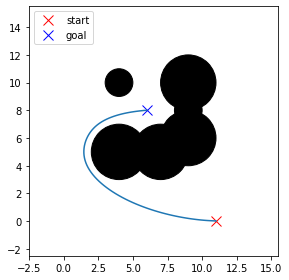

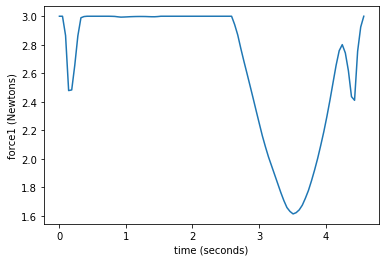

None

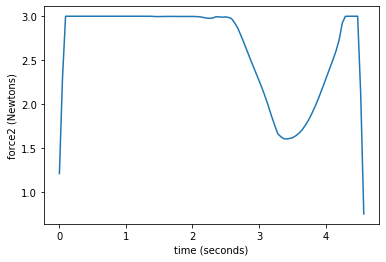

None

In [ ]:
def quadrotor_dircol():
    plant = Quadrotor2D()
    context = plant.CreateDefaultContext()

    N = 61
    max_dt = 0.5
    min_dt = 0.01
    max_tf = N*max_dt
    dircol = DirectCollocation(plant,
                            context,
                            num_time_samples = N,
                            minimum_timestep = min_dt,
                            maximum_timestep = max_dt)
    prog = dircol.prog()
    state = dircol.state()
     
    dircol.prog() 
    dircol.AddEqualTimeIntervalsConstraints()

    #---------------------------------ADD THRUST LIMIT CONSTRAINT
    thrust_limit = 3.0
    u = dircol.input()
    dircol.AddConstraintToAllKnotPoints(-thrust_limit <= u[0])
    dircol.AddConstraintToAllKnotPoints(u[0] <= thrust_limit)
    dircol.AddConstraintToAllKnotPoints(-thrust_limit <= u[1])
    dircol.AddConstraintToAllKnotPoints(u[1] <= thrust_limit)


    #---------------------------------ADD INITIAL STATE
    initial_x = float(start[0])
    initial_y = float(start[1])
    initial_theta = 0.0
    initial_state = (initial_x, initial_y, initial_theta, 0., 0., 0.)
    prog.AddBoundingBoxConstraint(initial_state, initial_state, dircol.initial_state())


    #---------------------------------ADD FINAL STATE
    final_x = float(goal[0])
    final_y = float(goal[1])
    final_theta = 0.0
    final_state = (final_x, final_y, final_theta, 0., 0., 0.)
    prog.AddBoundingBoxConstraint(final_state, final_state, dircol.final_state())

    #----------------------------------CONSTRAIN THETA
    dircol.AddConstraintToAllKnotPoints(state[2]<=90)
    dircol.AddConstraintToAllKnotPoints(state[2]>=-90)

    #---------------------------------ADD COLLISION AVOIDANCE CONSTRAINT
    for ob in obstacles:
        radius = ob[2] + 0.5
        ob_x = ob[0]
        ob_y = ob[1]
        diff_x = state[0]-ob_x
        diff_y = state[1]-ob_y
        dircol.AddConstraintToAllKnotPoints(((diff_x**2) + (diff_y**2))**0.5 >= radius)


    #----------------------------------RUNNING COST
    R = 10  # Cost on input "effort".
    for i in range(len(u)):
        dircol.AddRunningCost(R*(u[i]**2))

    # FINAL COST
    dircol.AddFinalCost(dircol.time())

    #---------------------------------INITIAL GUESS
    initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
        list(breaks), RRT_guess.T
    )

    dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)
    
    #---------------------------------SOLVE
    result = Solve(prog)
    assert result.is_success()

    #--------------------------------REBUILD TRAJECTORIES
    x_trajectory = dircol.ReconstructStateTrajectory(result)
    time_x = np.linspace(x_trajectory.start_time(), x_trajectory.end_time(), 100)
    x_knots = np.hstack([
        x_trajectory.value(t) for t in np.linspace(x_trajectory.start_time(),
                                                x_trajectory.end_time(), 100)])

    u_trajectory = dircol.ReconstructInputTrajectory(result)
    time_u = np.linspace(u_trajectory.start_time(), u_trajectory.end_time(), 100)
    u_knots = np.hstack([
        u_trajectory.value(t) for t in time_u])
    
    #---------------------------------PLOTTING
    def plot_scene(obstacle_list, start, goal, traj):
        ax = plt.gca()
        for o in obstacle_list:
            circle = plt.Circle((o[0], o[1]), o[2], color='k')
            ax.add_artist(circle)
        plt.axis([bounds[0]-0.5, bounds[1]+0.5, bounds[0]-0.5, bounds[1]+0.5])
        plt.plot(start[0], start[1], "xr", markersize=10)
        plt.plot(goal[0], goal[1], "xb", markersize=10)
        plt.plot(traj[0],traj[1])
        plt.plot()
        plt.legend(('start', 'goal'), loc='upper left')
        plt.gca().set_aspect('equal')
    
    plt.figure()
    plot_scene(obstacles, start, goal,[x_knots[0,:], x_knots[1,:]])
    plt.tight_layout()

    plt.figure(2)
    plt.plot(time_u,u_knots[0,:])
    plt.xlabel("time (seconds)")
    plt.ylabel("force1 (Newtons)")
    display(plt.show())

    plt.figure(3)
    plt.plot(time_u,u_knots[1,:])
    plt.xlabel("time (seconds)")
    plt.ylabel("force2 (Newtons)")
    display(plt.show())

    return x_trajectory, u_trajectory



x_trajectory2D, u_trajectory2D = quadrotor_dircol()
#print(np.pi/2)

# 2D LQR Trajectory Stabilization

In [ ]:
def finite_horizon_lqr(x_trajectory, u_trajectory, obstacle_list, plot=False):
    options = FiniteHorizonLinearQuadraticRegulatorOptions()
    options.x0 = x_trajectory
    options.u0 = u_trajectory

    #-------------------------------SETUP
    builder = DiagramBuilder()
    plant = builder.AddSystem(Quadrotor2D())
    context = plant.CreateDefaultContext()
    Q = np.diag([1.,1.,1.,1.,1.,1.])
    options.Qf = Q
    regulator = builder.AddSystem(
        MakeFiniteHorizonLinearQuadraticRegulator(plant,
                                                  context,
                                                  t0=options.u0.start_time(),
                                                  tf=options.u0.end_time(),
                                                  Q=Q,
                                                  R=np.eye(2),
                                                  options=options,))
    
    builder.Connect(regulator.get_output_port(0), plant.get_input_port(0))
    builder.Connect(plant.get_output_port(0), regulator.get_input_port(0))
    input_logger = LogVectorOutput(regulator.get_output_port(0), builder)
    state_logger = LogVectorOutput(plant.get_output_port(0), builder)


    #---------------------------Quadrotor 2D Visualizer (object moves out of window)
    visualizer = builder.AddSystem(
        Quadrotor2DVisualizer(show=False))

    # SET AXES AND PLACE OBSTACLES
    visualizer.ax.set_xlim(-5,15)
    visualizer.ax.set_ylim(-5,15)
    for o in obstacle_list:
        circle = plt.Circle((o[0], o[1]), o[2], color='k')
        visualizer.ax.add_artist(circle)


    builder.Connect(plant.get_output_port(0),
                    visualizer.get_input_port(0))
 
    
    #--------------------------- SIMULATION (a few random states)
    diagram = builder.Build()
    simulator = Simulator(diagram)
    simcontext = simulator.get_mutable_context()

    for i in range(3):
        rand = 0.5*np.random.randn(6,)
        start_state = np.array([start[0],start[1],0.,0.,0.,0.]) + rand
        print(start_state)
        simcontext.SetTime(0.)
        simcontext.SetContinuousState(start_state)
        simulator.Initialize()
        AdvanceToAndVisualize(simulator, visualizer,
                          options.u0.end_time() if running_as_notebook else 0.1)
    
    #----------------------------------PLOTTING    
    if plot:
        fig, ax = plt.subplots(4,1)
        ax[0].plot(options.u0.get_segment_times(),
                options.u0.vector_values(options.u0.get_segment_times())[0].T)
        input_log = input_logger.FindLog(simulator.get_context())
        ax[0].plot(input_log.sample_times(), input_log.data()[0].T)
        ax[0].legend(('u1 nominal','u1 actual'))

        ax[1].plot(options.u0.get_segment_times(),
                options.u0.vector_values(options.u0.get_segment_times())[1].T)
        input_log = input_logger.FindLog(simulator.get_context())
        ax[1].plot(input_log.sample_times(), input_log.data()[1].T)
        ax[1].legend(('u1 nominal','u1 actual'))

        ax[2].plot(options.x0.get_segment_times(),
                options.x0.vector_values(options.x0.get_segment_times())[0].T, 'b')
        state_log = state_logger.FindLog(simulator.get_context())
        ax[2].plot(state_log.sample_times(), state_log.data()[0].T, 'g')
        ax[2].legend(('x nominal','x actual'))

        ax[3].plot(options.x0.get_segment_times(),
                options.x0.vector_values(options.x0.get_segment_times())[1].T, 'b')
        state_log = state_logger.FindLog(simulator.get_context())
        ax[3].plot(state_log.sample_times(), state_log.data()[0].T, 'g')
        ax[3].legend(('y nominal','y actual'))

        def plot_scene(figure,obstacle_list, start, goal, traj):
            ax = plt.gca()
            for o in obstacle_list:
                circle = plt.Circle((o[0], o[1]), o[2], color='k')
                ax.add_artist(circle)
            plt.axis([bounds[0]-0.5, bounds[1]+0.5, bounds[0]-0.5, bounds[1]+0.5])
            plt.plot(start[0], start[1], "xr", markersize=10)
            plt.plot(goal[0], goal[1], "xb", markersize=10)
            plt.plot(traj[0],traj[1])
            plt.plot()
            plt.legend(('start', 'goal'), loc='upper left')
            plt.gca().set_aspect('equal')
        
        fig2 = plt.figure(figsize=(5,5))
        plot_scene(fig2,obstacle_list,start,goal, [options.x0.vector_values(options.x0.get_segment_times())[0].T,
                                                options.x0.vector_values(options.x0.get_segment_times())[1].T])
        plt.plot(state_log.data()[0].T,state_log.data()[1].T, 'g-')


        display(plt.show())

finite_horizon_lqr(x_trajectory2D, u_trajectory2D, obstacles, plot=True)

[11.5903056  -0.48263713 -0.66756116 -0.2492898   0.69394683  0.34757367]
simulating...  done.
generating animation...


[ 9.84005632e+00  9.50139459e-02  1.72854550e-02  2.84681197e-01
 -1.35633320e-01  6.50737469e-03]
simulating...  done.
generating animation...


[11.2410005   0.24402261 -0.51177936  0.11274804  0.90392019 -0.30190236]
simulating...  done.
generating animation...


KeyboardInterrupt: 

# Initial 3D Obstacle Fields

In [ ]:
#obstacles3D = [ # circles parametrized by [x, y, z, radius]
#        np.array([3, 0, 0, 2]),
#        np.array([3, 2, 0, 1]),
#        np.array([3, 4, 0, 2]),
#        np.array([-2, -1, 0, 2]),
#        np.array([1, -1, 0, 2]),
#        np.array([-2, 4, 0, 1])
#]



#start3D = np.array([-4,-5.5,0.2])
#goal3D = np.array([2,4.5,0.2])
#bounds3D = np.array([[-4.1,8],[-5.6,8],[0,4]]) #all obstacles will have height of 5

start3D = np.array([5, -4, 0]) # Start location
goal3D = np.array([0, 2, 0]) # Goal location

obstacles3D = [ # circles parametrized by [x, y, z, radius]
        np.array([3, 0, 0, 2]),
        np.array([3, 2, 0, 1]),
        np.array([3, 4, 0, 2]),
        np.array([-2, -1, 0, 2]),
        np.array([1, -1, 0, 2]),
        np.array([-2, 4, 0, 1])
] 

bounds3D = np.array([-6, 11]) # Bounds in both x and y and z

RRT3D_guess = [(5.0, -4.0, 0.0), (4.810510927367304, -3.7176959662168034, 0.21070909772132934), (4.621021854734607, -3.435391932433607, 0.4214181954426587), (4.431532782101911, -3.1530878986504103, 0.6321272931639881), (4.242043709469215, -2.8707838648672137, 0.8428363908853174), (4.052554636836518, -2.588479831084017, 1.0535454886066467), (3.863065564203822, -2.3061757973008206, 1.2642545863279762), (3.6735764915711258, -2.023871763517624, 1.4749636840493054), (3.4840874189384294, -1.7415677297344274, 1.6856727817706347), (3.294598346305733, -1.4592636959512308, 1.896381879491964), (3.105109273673037, -1.1769596621680343, 2.1070909772132933), (3.0782479542653824, -1.1369412129975158, 2.1369603744157537), (2.8262931203967567, -0.8801823313482129, 1.9620500019833778), (2.574338286528131, -0.62342344969891, 1.7871396295510018), (2.3223834526595053, -0.366664568049607, 1.6122292571186259), (2.0704286187908796, -0.10990568640030407, 1.43731888468625), (1.8184737849222539, 0.14685319524899887, 1.262408512253874), (1.5665189510536282, 0.4036120768983018, 1.087498139821498), (1.3145641171850024, 0.6603709585476047, 0.9125877673891221), (1.0626092833163767, 0.9171298401969077, 0.7376773949567461), (0.810654449447751, 1.1738887218462106, 0.5627670225243702), (0.5586996155791253, 1.4306476034955136, 0.3878566500919942), (0.30674478171049957, 1.6874064851448165, 0.21294627765961827), (0.054789947841873854, 1.9441653667941194, 0.03803590522724232)]
RRT3D_guess = np.array(RRT3D_guess)
RRT3D_guess = np.hstack([RRT3D_guess, np.zeros((RRT3D_guess.shape[0], 9))])

#print(RRT3D_guess.T)

breaks3D = np.linspace(0.0, 0.5*61, len(RRT3D_guess)) 

# Approximating Boxes with Ellipses

In [ ]:
def get_ellipses(obstacles):

    epsilon_xy = 0.1
    ellipses = []
    for box in box_obstacles:
        x,y,z,w,h,d = box

        max_dim= max(w,h)
        a = w/2 + epsilon_xy*(w/2)**0.5 #/np.sqrt(2) #+ epsilon
        b = h/2 + epsilon_xy*(h/2)**0.5 #/np.sqrt(2) #+ epsilon
        c = d/2 * max_dim
        ellipses.append([x,y,z,a,b,c])
    return a,b,c

def get_ellipses_params(obstacle):
    epsilon_xy = 0.1
    x,y,z,w,h,d = obstacle
    max_dim= max(w,h)
    a = w/2 + epsilon_xy*(w/2)**0.5 #/np.sqrt(2) #+ epsilon
    b = h/2 + epsilon_xy*(h/2)**0.5 #/np.sqrt(2) #+ epsilon
    c = d/2 * max_dim
    ellipse = [x,y,z,a,b,c]
    return a,b,c

spheres = False
box = False
maze = True

if spheres: # SPHERICAL COURSE 1
    obstacles3D = [ # circles parametrized by [x, y, z, radius]
        np.array([3, 0, 0, 2]),
        np.array([3, 2, 0, 1]),
        np.array([3, 4, 0, 2]),
        np.array([-2, -1, 0, 2]),
        np.array([1, -1, 0, 2]),
        np.array([-2, 4, 0, 1])
    ] 
    start3D = np.array([5, -4, 0]) # Start location
    goal3D = np.array([0, 2, 0])
    bounds3D = np.array([-6, 11]) # Bounds in both x and y and z

    RRT3D_guess = [(5.0, -4.0, 0.0), (4.810510927367304, -3.7176959662168034, 0.21070909772132934), (4.621021854734607, -3.435391932433607, 0.4214181954426587), (4.431532782101911, -3.1530878986504103, 0.6321272931639881), (4.242043709469215, -2.8707838648672137, 0.8428363908853174), (4.052554636836518, -2.588479831084017, 1.0535454886066467), (3.863065564203822, -2.3061757973008206, 1.2642545863279762), (3.6735764915711258, -2.023871763517624, 1.4749636840493054), (3.4840874189384294, -1.7415677297344274, 1.6856727817706347), (3.294598346305733, -1.4592636959512308, 1.896381879491964), (3.105109273673037, -1.1769596621680343, 2.1070909772132933), (3.0782479542653824, -1.1369412129975158, 2.1369603744157537), (2.8262931203967567, -0.8801823313482129, 1.9620500019833778), (2.574338286528131, -0.62342344969891, 1.7871396295510018), (2.3223834526595053, -0.366664568049607, 1.6122292571186259), (2.0704286187908796, -0.10990568640030407, 1.43731888468625), (1.8184737849222539, 0.14685319524899887, 1.262408512253874), (1.5665189510536282, 0.4036120768983018, 1.087498139821498), (1.3145641171850024, 0.6603709585476047, 0.9125877673891221), (1.0626092833163767, 0.9171298401969077, 0.7376773949567461), (0.810654449447751, 1.1738887218462106, 0.5627670225243702), (0.5586996155791253, 1.4306476034955136, 0.3878566500919942), (0.30674478171049957, 1.6874064851448165, 0.21294627765961827), (0.054789947841873854, 1.9441653667941194, 0.03803590522724232)]
    RRT3D_guess = np.array(RRT3D_guess)
    RRT3D_guess = np.hstack([RRT3D_guess, np.zeros((RRT3D_guess.shape[0], 9))])


if box:
    # Course 2 BOX OBSTACLES WHICH WILL BE ESTIMATED BY AN ELLIPSE
    obstacles3D = np.array([
        np.array([-2,-2,2, 2,0.5,4]),
        np.array([-0.75,-1,2, 0.5,2,4]),
        np.array([-3.25,-1,2, 0.5,2,4])
    ])


    start3D = np.array([-2,-4,0.2])
    goal3D = np.array([-2,-1,0.2])
    bounds3D = np.array([[-8,8],[-8,8],[0,4]]) #all obstacles will have height of 5

    RRT3D_guess = [(-2.0, -4.0, 0.2), (-2.1409002935364425, -3.9108999036182968, 0.31049097983875346), (-2.281800587072885, -3.8217998072365935, 0.4209819596775069), (-2.4227008806093275, -3.7326997108548903, 0.5314729395162603), (-2.56360117414577, -3.643599614473187, 0.6419639193550137), (-2.7045014676822126, -3.554499518091484, 0.7524548991937672), (-2.845401761218655, -3.4653994217097805, 0.8629458790325206), (-2.9863020547550976, -3.3762993253280773, 0.9734368588712741), (-3.12720234829154, -3.287199228946374, 1.0839278387100275), (-3.2681026418279826, -3.198099132564671, 1.194418818548781), (-3.409002935364425, -3.1089990361829676, 1.3049097983875344), (-3.5499032289008676, -3.0198989398012643, 1.4154007782262878), (-3.69080352243731, -2.930798843419561, 1.5258917580650413), (-3.8317038159737526, -2.841698747037858, 1.6363827379037947), (-3.972604109510195, -2.7525986506561546, 1.7468737177425482), (-4.113504403046638, -2.6634985542744514, 1.8573646975813016), (-4.25440469658308, -2.574398457892748, 1.967855677420055), (-4.395304990119523, -2.485298361511045, 2.0783466572588085), (-4.40030573181091, -2.4821360787684075, 2.0822681313418907), (-4.442097210139171, -2.287116731081982, 2.067405546512587), (-4.483888688467433, -2.092097383395557, 2.0525429616832835), (-4.525680166795694, -1.8970780357091317, 2.03768037685398), (-4.567471645123955, -1.7020586880227064, 2.0228177920246764), (-4.609263123452217, -1.5070393403362812, 2.007955207195373), (-4.651054601780478, -1.312019992649856, 1.9930926223660692), (-4.6928460801087395, -1.1170006449634307, 1.9782300375367656), (-4.734637558437001, -0.9219812972770054, 1.963367452707462), (-4.776429036765262, -0.7269619495905801, 1.9485048678781585), (-4.818220515093524, -0.5319426019041549, 1.9336422830488549), (-4.860011993421785, -0.3369232542177296, 1.9187796982195513), (-4.901803471750046, -0.14190390653130436, 1.9039171133902477), (-4.943594950078308, 0.0531154411551209, 1.8890545285609441), (-4.958655226227892, 0.12339400865634964, 1.8836985411496414), (-4.773658708392937, 0.19583465863236757, 1.8607070798905991), (-4.588662190557983, 0.2682753086083855, 1.8377156186315569), (-4.403665672723029, 0.3407159585844034, 1.8147241573725146), (-4.218669154888074, 0.41315660856042136, 1.7917326961134723), (-4.03367263705312, 0.4855972585364393, 1.76874123485443), (-3.8486761192181653, 0.5580379085124572, 1.7457497735953877), (-3.663679601383211, 0.6304785584884751, 1.7227583123363455), (-3.4786830835482565, 0.7029192084644931, 1.6997668510773032), (-3.293686565713302, 0.775359858440511, 1.676775389818261), (-3.1086900478783477, 0.847800508416529, 1.6537839285592186), (-2.9236935300433933, 0.9202411583925468, 1.6307924673001764), (-2.738697012208439, 0.9926818083685648, 1.607801006041134), (-2.7384200040466027, 0.9927902787956153, 1.607766579325994), (-2.6716067139515767, 0.81247978576174, 1.5527749965519086), (-2.6047934238565507, 0.6321692927278646, 1.4977834137778232), (-2.5379801337615246, 0.45185879969398923, 1.4427918310037378), (-2.4711668436664986, 0.27154830666011387, 1.3878002482296523), (-2.4043535535714726, 0.0912378136262385, 1.3328086654555669), (-2.3375402634764466, -0.08907267940763686, 1.2778170826814814), (-2.2707269733814206, -0.2693831724415121, 1.222825499907396), (-2.2039136832863946, -0.4496936654753876, 1.1678339171333105), (-2.1371003931913686, -0.6300041585092631, 1.112842334359225), (-2.0702871030963426, -0.8103146515431383, 1.0578507515851396), (-2.0034738130013166, -0.9906251445770136, 1.0028591688110542)]

    RRT3D_guess = np.array(RRT3D_guess)
    RRT3D_guess = np.hstack([RRT3D_guess, np.zeros((RRT3D_guess.shape[0], 9))])

if maze:
    # Course 3 Box OBSTACLES IN MAZE ESTIMATED BY ELLIPSE

    obstacles3D = np.array([

        np.array([-5,-3,2, 0.5,6,4]),
        np.array([-3,-3.75,2, 0.5,4.5,4]),

        np.array([-2,0.25,2, 6.5,0.5,4]),
        np.array([0,-1.75,2, 5.5,0.5,4]),

        np.array([1.,2.75,2, 0.5,4.5,4]),
        np.array([3,1.5,2, 0.5,7,4]),

    ])

    #ellipses = get_ellipses(box_obstacles)
    start3D = np.array([-4,-5.5,0.2])
    goal3D = np.array([2,4.5,0.2])
    bounds3D = np.array([[-4.1,8],[-5.6,8],[0,4]]) #all obstacles will have height of 5

    RRT3D_guess = [(-4.0, -5.5, 0.2), (-3.988842146397086, -5.307527665474535, 0.2531966549578014), (-3.977684292794172, -5.115055330949071, 0.3063933099156028), (-3.966526439191258, -4.922582996423606, 0.3595899648734042), (-3.955368585588344, -4.7301106618981414, 0.4127866198312056), (-3.94421073198543, -4.537638327372677, 0.46598327478900703), (-3.933052878382516, -4.345165992847212, 0.5191799297468085), (-3.921895024779602, -4.1526936583217475, 0.5723765847046098), (-3.910737171176688, -3.960221323796283, 0.6255732396624112), (-3.899579317573774, -3.7677489892708182, 0.6787698946202126), (-3.88842146397086, -3.5752766547453536, 0.7319665495780141), (-3.877263610367946, -3.382804320219889, 0.7851632045358155), (-3.866105756765032, -3.1903319856944243, 0.8383598594936168), (-3.854947903162118, -2.9978596511689597, 0.8915565144514181), (-3.843790049559204, -2.805387316643495, 0.9447531694092197), (-3.83263219595629, -2.6129149821180304, 0.9979498243670211), (-3.821474342353376, -2.4204426475925658, 1.0511464793248224), (-3.810316488750462, -2.227970313067101, 1.1043431342826238), (-3.799158635147548, -2.0354979785416365, 1.1575397892404253), (-3.788000781544634, -1.8430256440161719, 1.2107364441982267), (-3.77684292794172, -1.6505533094907072, 1.263933099156028), (-3.765685074338806, -1.4580809749652426, 1.3171297541138294), (-3.7606457828762085, -1.3711534863390096, 1.3411552933176765), (-3.5682801613285275, -1.3554738381952876, 1.2887186702112432), (-3.3759145397808465, -1.3397941900515655, 1.23628204710481), (-3.1835489182331655, -1.3241145419078435, 1.1838454239983767), (-2.9911832966854845, -1.3084348937641215, 1.1314088008919434), (-2.7988176751378036, -1.2927552456203995, 1.0789721777855101), (-2.6064520535901226, -1.2770755974766774, 1.0265355546790769), (-2.4140864320424416, -1.2613959493329554, 0.9740989315726436), (-2.2217208104947606, -1.2457163011892334, 0.9216623084662103), (-2.0293551889470796, -1.2300366530455114, 0.8692256853597771), (-1.8369895673993986, -1.2143570049017893, 0.8167890622533438), (-1.6446239458517176, -1.1986773567580673, 0.7643524391469105), (-1.4522583243040366, -1.1829977086143453, 0.7119158160404773), (-1.2598927027563556, -1.1673180604706233, 0.659479192934044), (-1.0675270812086746, -1.1516384123269012, 0.6070425698276107), (-0.8751614596609936, -1.1359587641831792, 0.5546059467211775), (-0.6827958381133126, -1.1202791160394572, 0.5021693236147442), (-0.49043021656563157, -1.1045994678957352, 0.44973270050831093), (-0.2980645950179506, -1.0889198197520131, 0.39729607740187767), (-0.10569897347026957, -1.073240171608291, 0.3448594542954444), (0.08666664807741142, -1.057560523464569, 0.29242283118901113), (0.27903226962509287, -1.041880875320847, 0.23998620808257787), (0.4713978911727734, -1.026201227177125, 0.1875495849761446), (0.663763512720454, -1.010521579033403, 0.13511296186971133), (0.809189862738374, -0.9986679329361374, 0.09547143629834798), (0.9108220712471294, -0.8336127693692016, 0.1447427605844243), (1.0124542797558849, -0.6685576058022658, 0.19401408487050065), (1.1140864882646402, -0.5035024422353299, 0.24328540915657698), (1.2157186967733957, -0.3384472786683941, 0.2925567334426533), (1.3173509052821513, -0.17339211510145824, 0.34182805772872965), (1.4189831137909066, -0.008336951534522408, 0.391099382014806), (1.520615322299662, 0.15671821203241354, 0.4403707063008823), (1.6222475308084174, 0.32177337559934927, 0.48964203058695865), (1.723879739317173, 0.486828539166285, 0.5389133548730349), (1.8255119478259283, 0.6518837027332209, 0.5881846791591113), (1.9271441563346836, 0.8169388663001569, 0.6374560034451877), (2.028776364843439, 0.9819940298670926, 0.686727327731264), (2.1304085733521947, 1.1470491934340283, 0.7359986520173403), (2.23204078186095, 1.3121043570009645, 0.7852699763034167), (2.3336729903697053, 1.4771595205679002, 0.834541300589493), (2.435305198878461, 1.642214684134836, 0.8838126248755693), (2.5189734782899125, 1.7780956390629346, 0.9243750311031635), (2.482733033182549, 1.9681689852097846, 0.873791186937674), (2.446492588075185, 2.1582423313566346, 0.8232073427721844), (2.4102521429678214, 2.348315677503485, 0.7726234986066949), (2.3740116978604577, 2.5383890236503346, 0.7220396544412053), (2.337771252753094, 2.7284623697971844, 0.6714558102757158), (2.3015308076457304, 2.9185357159440346, 0.6208719661102262), (2.2652903625383667, 3.108609062090885, 0.5702881219447367), (2.229049917431003, 3.2986824082377346, 0.5197042777792471), (2.1928094723236393, 3.4887557543845844, 0.46912043361375755), (2.1565690272162756, 3.6788291005314346, 0.418536589448268), (2.120328582108912, 3.868902446678285, 0.36795274528277844), (2.0840881370015483, 4.058975792825135, 0.3173689011172889), (2.0478476918941846, 4.249049138971984, 0.2667850569517993), (2.011607246786821, 4.439122485118835, 0.21620121278630977)]
    RRT3D_path = RRT3D_guess
    RRT3D_guess = np.array(RRT3D_guess)
    RRT3D_guess = np.hstack([RRT3D_guess, np.zeros((RRT3D_guess.shape[0], 9))])


breaks3D = np.linspace(0.0, 0.5*61, len(RRT3D_guess)) 

# 3D Quadrotor Direct Collocation

hello
[-5.  -3.   2.   0.5  6.   4. ]
[-3.   -3.75  2.    0.5   4.5   4.  ]
[-2.    0.25  2.    6.5   0.5   4.  ]
[ 0.   -1.75  2.    5.5   0.5   4.  ]
[1.   2.75 2.   0.5  4.5  4.  ]
[3.  1.5 2.  0.5 7.  4. ]


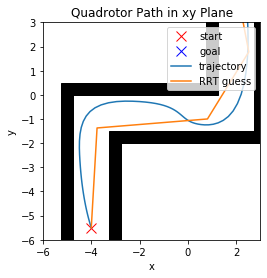

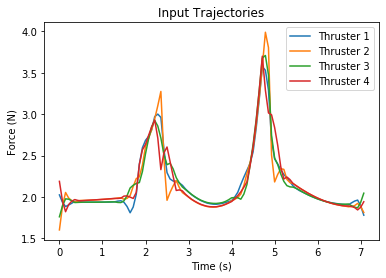

In [ ]:
def quadrotor3D_dircol():
    plant = QuadrotorPlant()
    context = plant.CreateDefaultContext()
    N = 61
    max_dt = 0.5
    min_dt = 0.01
    max_tf = N*max_dt
    dircol = DirectCollocation(plant,
                            context,
                            num_time_samples = N,
                            minimum_timestep = min_dt,
                            maximum_timestep = max_dt)
    prog = dircol.prog()
    state = dircol.state()
    u = dircol.input()
     
    dircol.prog() 
    dircol.AddEqualTimeIntervalsConstraints()


    if len(obstacles3D[0])==6:
        print('hello')
        dircol.AddConstraintToAllKnotPoints(state[2]>=0.1)
        dircol.AddConstraintToAllKnotPoints(state[2]<=5)
    #dircol.AddConstraintToAllKnotPoints(state[1]>=-10)
    #dircol.AddConstraintToAllKnotPoints(state[1]<=10)
    #dircol.AddConstraintToAllKnotPoints(state[0]>=-10)
    #dircol.AddConstraintToAllKnotPoints(state[0]<=10)


    #----------------------------------CONSTRAIN ROLL, PITCH, YAW
    dircol.AddConstraintToAllKnotPoints(state[4]<= (np.pi/2 - 0.1))
    dircol.AddConstraintToAllKnotPoints(state[4]>=-(np.pi/2 - 0.2))    
    dircol.AddConstraintToAllKnotPoints(state[3]<= (np.pi - 0.1))
    dircol.AddConstraintToAllKnotPoints(state[3]>=-(np.pi - 0.1))
    dircol.AddConstraintToAllKnotPoints(state[5]<= (np.pi - 0.1))
    dircol.AddConstraintToAllKnotPoints(state[5]>=-(np.pi - 0.1))



    #---------------------------------ADD COLLISION AVOIDANCE CONSTRAINT
    for ob in obstacles3D:
        ob_x = ob[0]
        ob_y = ob[1]
        ob_z = ob[2]
        diff_x = state[0]-ob_x
        diff_y = state[1]-ob_y
        diff_z = state[2]-ob_z
        if len(ob) == 4:  # SPHERICAL OBSTACLES
            #print('hi')
            radius = ob[3] + 1 #rework tolerance based on feasibility
            dircol.AddConstraintToAllKnotPoints(((diff_x**2) + (diff_y**2) + (diff_z**2))**0.5 >= radius)

        if len(ob) == 6:  # RECTANGULAR OBSTACLES
            # think about approximating with an ellipse
            width = ob[3]
            height = ob[4]
            depth = ob[5]
            a,b,c = get_ellipses_params(ob)
            #if (xp-w)**2/(a**2) + (yp-h)**2/(b**2) + (zp-d)**2/(c**2) >= 1: # OUTSIDE ELLIPSE
            func = (diff_x)**2/(a**2) + (diff_y)**2/(b**2) + (diff_z)**2/(c**2)
            dircol.AddConstraintToAllKnotPoints(func >= 3)

    #---------------------------------ADD Initial States
    initial_x = float(start3D[0])
    initial_y = float(start3D[1])
    initial_z = float(start3D[2])
    initial_state = (initial_x, initial_y, initial_z, 0., 0., 0., 0., 0., 0., 0., 0., 0.)
    prog.AddBoundingBoxConstraint(initial_state, initial_state, dircol.initial_state())


    #---------------------------------ADD Final States
    final_x = float(goal3D[0])
    final_y = float(goal3D[1])
    final_z = float(goal3D[2])
    final_state = (final_x, final_y, final_z, 0., 0., 0., 0., 0., 0., 0., 0., 0.)
    prog.AddBoundingBoxConstraint(final_state, final_state, dircol.final_state())

    

    #----------------------------------Running COST
    R = 10  # Cost on input "effort".
    Q = 1
    for i in range(len(u)):
        dircol.AddRunningCost(R*(u[i]**2))

    # FINAL COST
    dircol.AddFinalCost(dircol.time())

    #-------------------------------- INITIAL GUESS
    initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
        list(breaks3D), RRT3D_guess.T)

    dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)
    
    #---------------------------------SOLVE
    result = Solve(prog)
    assert result.is_success()

    #---------------------------------REBUILD TRAJECTORIES
    x_trajectory = dircol.ReconstructStateTrajectory(result)
    time_x = np.linspace(x_trajectory.start_time(), x_trajectory.end_time(), 100)
    x_knots = np.hstack([
        x_trajectory.value(t) for t in np.linspace(x_trajectory.start_time(),
                                                x_trajectory.end_time(), 100)])

    u_trajectory = dircol.ReconstructInputTrajectory(result)
    time_u = np.linspace(u_trajectory.start_time(), u_trajectory.end_time(), 100)
    u_knots = np.hstack([
        u_trajectory.value(t) for t in time_u])
    
    #--------------------------------- PLOT
    def plot_scene(obstacles, start, goal, bounds, traj):
        ax = plt.gca()
        for o in obstacles:
            if len(o)==4:
                print('hi')
                circle = plt.Circle((float(o[0]), float(o[1])), radius=o[3],color = 'k')
                ax.add_artist(circle)
            if len(o)==6:
                #x,y,z,w,h,d 
                print(o)
                xll = o[0]-(o[3]/2)
                yll = o[1]-(o[4]/2)
                rect = plt.Rectangle((float(xll), float(yll)), o[3],o[4], color = 'k')
                ax.add_artist(rect)

        #plt.axis([bounds[0,0]-0.5, bounds[0,1]+0.5, bounds[1,0]-0.5, bounds[1,1]+0.5])
        plt.axis([-6,3, -6, 3])
        plt.plot(start[0], start[1], "xr", markersize=10)
        plt.plot(goal[0], goal[1], "xb", markersize=10)
        plt.plot(traj[0],traj[1])
        plt.plot()
        plt.legend(('start', 'goal'), loc='upper left')
        plt.gca().set_aspect('equal')
    
    plt.figure()
    plot_scene(obstacles3D, start3D, goal3D, bounds3D, [x_knots[0,:], x_knots[1,:]])
    plt.plot(RRT3D_guess.T[0,:], RRT3D_guess.T[1,:])
    plt.legend(('start','goal','trajectory','RRT guess'),loc='upper right')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Quadrotor Path in xy Plane')
    plt.savefig('QuadrotorBox_1_xy.png')
    #plt.tight_layout()

    #plt.figure(2)
    #plt.plot(time_u,u_knots[0,:])
    #plt.title('Thruster 1')
    #plt.xlabel("Time (s)")
    #plt.ylabel("Force (N)")
    #plt.savefig('QuadrotorSpheres_thruster1.png')
    #display(plt.show())

    #plt.figure(3)
    #plt.plot(time_u,u_knots[1,:])
    #plt.title('Thruster 2')
    #plt.xlabel("Time (s)")
    #plt.ylabel("Force (N)")
    #plt.savefig('QuadrotorSpheres_thruster2.png')
    #display(plt.show())

    #plt.figure(4)
    #plt.plot(time_u,u_knots[2,:])
    #plt.title('Thruster 3')
    #plt.xlabel("Time (s)")
    #plt.ylabel("Force (N)")
    #plt.savefig('QuadrotorSpheres_thruster3.png')
    #display(plt.show())

    #plt.figure(5)
    #plt.plot(time_u,u_knots[3,:])
    #plt.title('Thruster 4')
    #plt.xlabel("Time (s)")
    #plt.ylabel("Force (N)")
    #plt.savefig('QuadrotorSpheres_thruster4.png')
    #display(plt.show())

    plt.figure(6)
    plt.plot(time_u,u_knots[0,:])
    plt.plot(time_u,u_knots[1,:])
    plt.plot(time_u,u_knots[2,:])
    plt.plot(time_u,u_knots[3,:])
    plt.legend(('Thruster 1', 'Thruster 2', 'Thruster 3', 'Thruster 4'))
    plt.title('Input Trajectories')
    plt.xlabel("Time (s)")
    plt.ylabel("Force (N)")
    plt.savefig('QuadrotorBox_1_inputs.png')

    return x_trajectory, x_knots, u_trajectory, u_knots


x_trajectory, x_knots, u_trajectory, u_knots = quadrotor3D_dircol()



# 3D LQR Trajectory Stabilization

[-4.17221757 -4.17230913 -4.17259954 ... -5.75600702 -5.75611734
 -5.75622669]


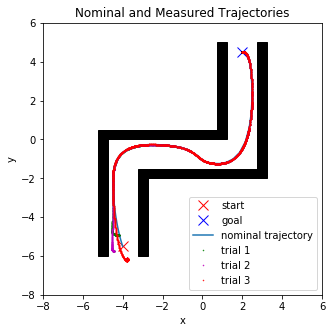

In [ ]:
def quadrotor_example(obstacles, path=None):
    options = FiniteHorizonLinearQuadraticRegulatorOptions()
    options.x0 = x_trajectory
    options.u0 = u_trajectory

    builder = DiagramBuilder()
    plant = builder.AddSystem(QuadrotorPlant())
    context = plant.CreateDefaultContext()
    Q = np.diag([10.,10.,10.,10.,10.,10.,1.,1.,1.,1.,1.,1.])
    options.Qf = Q

    #----------------------------MAKE REGULATOR AND CONNECT
    regulator = builder.AddSystem(
        MakeFiniteHorizonLinearQuadraticRegulator(plant,
                                                  context,
                                                  t0=options.u0.start_time(),
                                                  tf=options.u0.end_time(),
                                                  Q=Q,
                                                  R=np.eye(4),
                                                  options=options))
    builder.Connect(regulator.get_output_port(0), plant.get_input_port(0))
    builder.Connect(plant.get_output_port(0), regulator.get_input_port(0))
    input_logger = LogVectorOutput(regulator.get_output_port(0), builder)
    state_logger = LogVectorOutput(plant.get_output_port(0), builder)


    #---------------------------MESHCAT VISUALIZATION
    scene_graph = builder.AddSystem(SceneGraph())
    QuadrotorGeometry.AddToBuilder(builder, plant.get_output_port(0), scene_graph)

    mbp = builder.AddSystem(MultibodyPlant(time_step=0.0))
    mbp.RegisterAsSourceForSceneGraph(scene_graph)

    #for i, obs in enumerate(obstacles):  #SPHERES
    #    x,y,z,r = obs
    #    obstacle = AddShape(mbp, geometry.Sphere(r), f"obstacle_{i}", color = [1,0,0,1])
    #    mbp.WeldFrames(mbp.world_frame(), mbp.GetFrameByName(f"obstacle_{i}"),
    #                   RigidTransform(p=[x, y, z]))

    for i, obs in enumerate(obstacles): # RECTANGLES
        (x,y,z,w,h,d) = obs
        obstacle = AddShape(mbp, geometry.Box(w,h,d), name=f"box_{i}", color = [1,0,0,0.5])
        mbp.WeldFrames(mbp.world_frame(), mbp.GetFrameByName(f"box_{i}"), RigidTransform(p=[x,y,z]))

    if path is not None:
        for i, obs in enumerate(path):
            (x,y,z) = obs
            obstacle = AddShape(mbp, geometry.Sphere(0.05), name=f"path_i{i}", color = [1,1,1,0.5])
            mbp.WeldFrames(mbp.world_frame(), mbp.GetFrameByName(f"path_i{i}"), RigidTransform(p=[x,y,z]))

    # 
    builder.Connect(
        mbp.get_geometry_poses_output_port(),
        scene_graph.get_source_pose_port(mbp.get_source_id()),
    )
    builder.Connect(
        scene_graph.get_query_output_port(),
        mbp.get_geometry_query_input_port(),
    )
    mbp.Finalize()
        
    meshcat.Delete()
    meshcat.ResetRenderMode()
    meshcat.SetProperty('/Background','visible',False)
    visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)
    # end setup for visualization

    #----------------------------SIMULATOR
    diagram = builder.Build()
    simulator = Simulator(diagram)
    simulator.set_target_realtime_rate(1.0 if running_as_notebook else 0.0)
    simcontext = simulator.get_mutable_context()
    quad_context = plant.GetMyContextFromRoot(simcontext)


    #visualizer.StartRecording(False)
    for i in range(3):
        #state_logger = 0
        rand = 0.5*np.random.randn(12,)
        
        start_state = np.array([start3D[0],start3D[1],start3D[2],0.,0.,0.,0.,0.,0.,0.,0.,0.]) + rand
        simcontext.SetTime(0.)
        quad_context.SetContinuousState(start_state)
        visualizer.StartRecording(False)
        simulator.Initialize()
        simulator.AdvanceTo(x_trajectory.end_time())
        #state_log = state_logger.FindLog(simcontext)
        #ax[0].plot(state_log.sample_times(), state_log.data()[0].T, 'g')
        visualizer.PublishRecording()


    #fig, ax = plt.subplots(2,1)

    #ax[0].plot(options.x0.get_segment_times(),
            #options.x0.vector_values(options.x0.get_segment_times())[0].T, 'b')
    #state_log = state_logger.FindLog(simulator.get_context())
    #ax[0].plot(state_log.sample_times(), state_log.data()[0].T, 'g')
    #ax[0].legend(('x nominal','x actual'))

    #ax[0].plot(options.x0.get_segment_times(),
    #        options.x0.vector_values(options.x0.get_segment_times())[1].T, 'b')
    state_log = state_logger.FindLog(simulator.get_context())
    #ax[1].plot(state_log.sample_times(), state_log.data()[0].T, 'g')
    #ax[1].legend(('y nominal','y actual'))

    #plt.figure(2)
    #plt.plot(x_knots[0,:],x_knots[1,:], 'b')
    #plt.plot(state_log.data()[0], state_log.data()[1], 'g--')



    def plot_scene(figure,obstacle_list, start, goal, traj):
        ax = plt.gca()
        for o in obstacle_list:
            #circle = plt.Circle((o[0], o[1]), o[3], color='k')
            #ax.add_artist(circle)
            xll = o[0]-(o[3]/2)
            yll = o[1]-(o[4]/2)
            rect = plt.Rectangle((float(xll), float(yll)), o[3],o[4], color = 'k')
            ax.add_artist(rect)
        #plt.axis([bounds3D[0]-0.5, bounds3D[1]+0.5, bounds3D[0]-0.5, bounds3D[1]+0.5])
        plt.axis([-5,6,-5,6])
        plt.plot(start[0], start[1], "xr", markersize=10)
        plt.plot(goal[0], goal[1], "xb", markersize=10)
        plt.plot(traj[0],traj[1], markersize=50)
        plt.legend(('start', 'goal'), loc='upper left')
        plt.gca().set_aspect('equal')
    

    third = int(np.ceil(len(state_log.data()[0])/3))
    #print(third)
    x = state_log.data()[0]
    y = state_log.data()[1]
    #print(len(x[0:third+400 - 39]))
    #print(x[0:third])

    array1 = np.hstack([np.array(x[0:third-1].T),np.array(y[0:third-1].T)])
    print(array1)
    #print(len(options.x0.vector_values(options.x0.get_segment_times())[1]))

    fig2 = plt.figure(figsize=(5,5))
    #plot_scene(fig2,obstacles3D,start3D,goal3D, [options.x0.vector_values(options.x0.get_segment_times())[0].T,
    #                                            options.x0.vector_values(options.x0.get_segment_times())[1].T])
    plt.plot(start3D[0], start3D[1], "xr", markersize=10)
    plt.plot(goal3D[0], goal3D[1], "xb", markersize=10)
    for o in obstacles3D:
        ax = plt.gca()
        #circle = plt.Circle((o[0], o[1]), o[3], color='k')
        #ax.add_artist(circle)
        xll = o[0]-(o[3]/2)
        yll = o[1]-(o[4]/2)
        rect = plt.Rectangle((float(xll), float(yll)), o[3],o[4], color = 'k')
        ax.add_artist(rect)
    plt.plot(options.x0.vector_values(options.x0.get_segment_times())[0].T,options.x0.vector_values(options.x0.get_segment_times())[1].T)
    plt.plot(x[0:third-5],y[0:third-5], 'g.',markersize = 1)
    plt.plot(x[third+5:2*third-5],y[third+5:2*third-5], 'm.',markersize=1)
    plt.plot(x[2*third+5:],y[2*third+5:], 'r.',markersize=1)
    plt.axis([-8,6,-8,6])
    plt.title('Nominal and Measured Trajectories')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(('start', 'goal','nominal trajectory','trial 1', 'trial 2', 'trial 3'), loc='lower right')
    plt.savefig('LQRmaze.png')
    #plt.legend(('start', 'goal'), loc='upper right')

    #plt.show()
    

quadrotor_example(obstacles3D, path=RRT3D_path)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=931e8205-9a5c-4b8e-a3da-167564211c03' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>